# Simple FEM for a simple shear problem

## Create rectangular mesh

In [2]:
import copy
import numpy as np
import skfem as fem
from skfem.helpers import ddot, dot, eye, sym_grad, trace
from skfem.visuals.matplotlib import plot

DELTA = 0.1
MU = 1.0
LBD = 2.0

mesh = fem.MeshQuad().refined(5)

# Define second order quads and define a 2d variable on it (u1 and u2)
element = fem.ElementVector(fem.ElementQuad1(), 2)
# Function space
basis = fem.Basis(mesh, element)

# Material model for plane strain
def sigma(eps):
    return  2.0 * MU * eps + LBD * eye(trace(eps), 2)

# Bilinear form (RHS)
@fem.BilinearForm
def k(u, v, w):
    return ddot(sigma(sym_grad(u)), sym_grad(v))

# Linear form (LHS)
@fem.LinearForm
def b(v, w):
    f = np.zeros(v.shape)
    return dot(f, v)

## Simple shear with prescribed edges

Left and right boundary: 

$$ u_1 = \delta y$$
$$ u_2 = 0$$

Bottom boundary: 

$$ u_1 = 0$$
$$ u_2 = 0$$

Top boundary: 

$$ u_1 = \delta$$
$$ u_2 = 0$$

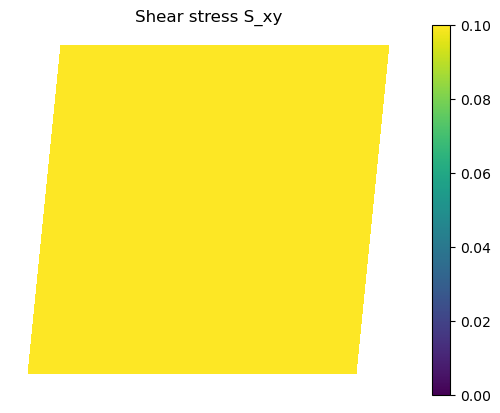

In [3]:
# Get all degrees of freedom and set appropiate entry to prescribed BCs.
u = basis.zeros()
x = np.zeros_like(u)
dofs0 = list(basis.nodal_dofs[0])
dofs1 = list(basis.nodal_dofs[1])
x[dofs0] = mesh.doflocs[0]
x[dofs1] = mesh.doflocs[1]
u[basis.get_dofs({"top"}).nodal['u^1']] = DELTA
u[basis.get_dofs({"left"}).nodal['u^1']] = DELTA * x[basis.get_dofs({"left"}).nodal['u^2']]
u[basis.get_dofs({"right"}).nodal['u^1']] = DELTA * x[basis.get_dofs({"right"}).nodal['u^2']]


cons = np.concatenate([
    basis.get_dofs({"bottom"}),
    basis.get_dofs({"top"}),
    basis.get_dofs({"left"}),
    basis.get_dofs({"right"}),
    ]
)

# Get remaining degrees of freedom
I = basis.complement_dofs(cons)


# Assemble matrices
K = fem.asm(k, basis)
B = fem.asm(b, basis)

# Solve the problem 
u = fem.solve(*fem.condense(K, B, x=u, I=I))

# Visualize result
dofs0 = list(basis.nodal_dofs[0]) 
dofs1 = list(basis.nodal_dofs[1]) 
defmesh = copy.deepcopy(mesh)
defmesh.doflocs[0] += u[dofs0]
defmesh.doflocs[1] += u[dofs1]
ui = basis.interpolate(u)
E = sym_grad(ui)
S = sigma(E)
p = plot(defmesh, np.mean(S[0,1], axis=-1), colorbar=True, cmap="viridis", vmin=0.0)
p.set_title("Shear stress S_xy")
p.show()

## Simple shear with free edges

Bottom boundary: 

$$ u_1 = 0$$
$$ u_2 = 0$$

Top boundary: 

$$ u_1 = \delta$$
$$ u_2 = 0$$

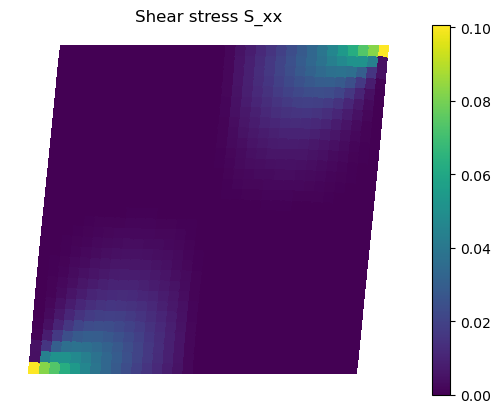

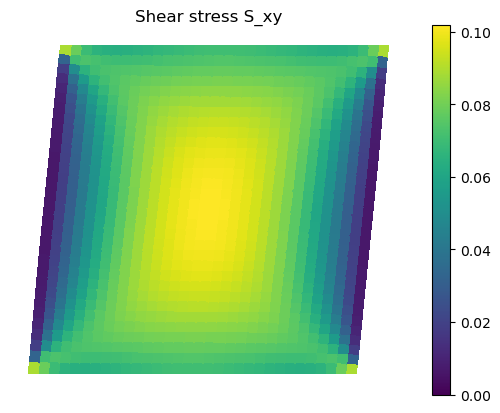

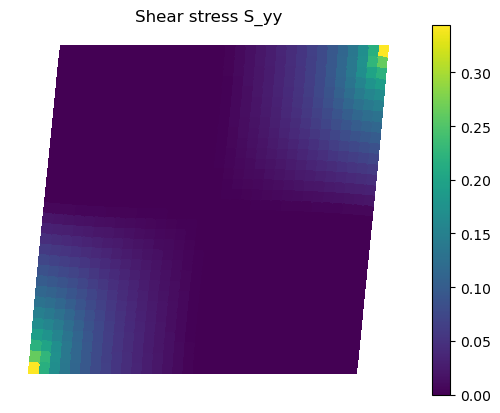

In [5]:
# Get all degrees of freedom and set appropiate entry to prescribed BCs.
u = basis.zeros()
u[basis.get_dofs({"top"}).nodal['u^1']] = DELTA


cons = np.concatenate([
    basis.get_dofs({"bottom"}),
    basis.get_dofs({"top"}),
    ]
)

# Get remaining degrees of freedom
I = basis.complement_dofs(cons)


# Assemble matrices
K = fem.asm(k, basis)
B = fem.asm(b, basis)

# Solve the problem 
u = fem.solve(*fem.condense(K, B, x=u, I=I))

# Visualize result
dofs0 = list(basis.nodal_dofs[0]) 
dofs1 = list(basis.nodal_dofs[1]) 
defmesh = copy.deepcopy(mesh)
defmesh.doflocs[0] += u[dofs0]
defmesh.doflocs[1] += u[dofs1]
ui = basis.interpolate(u)
E = sym_grad(ui)
S = sigma(E)

p = plot(defmesh, np.mean(S[0,0], axis=-1), colorbar=True, cmap="viridis", vmin=0.0)
p.set_title("Shear stress S_xx")
p.show()

p = plot(defmesh, np.mean(S[0,1], axis=-1), colorbar=True, cmap="viridis", vmin=0.0)
p.set_title("Shear stress S_xy")
p.show()

p = plot(defmesh, np.mean(S[1,1], axis=-1), colorbar=True, cmap="viridis", vmin=0.0)
p.set_title("Shear stress S_yy")
p.show()

